This is the code to perform PCA on weight matrix
===
Please setup a similar environment in case you want ot run this code on your machine.   

- __Software Environment__:  
    Anaconda 3.6  
    matplotlib  
    sklearn  
    numpy  
    pytorch 1.0  
    cupy  
    
- __Hardware Environment__:  
    32 cores Intel Xeon E5 CPU  
    64 GB RAM  
    2 TB SSD  
    Dual Nvidia Tesla V100 GPU (16 GB RAM each)  
- __Training Parameter__:  
    network: DNN with one square matrix hidden layer  
    starting learning rate: 1e-2  
    learning rate decay: uniform 3 stages, each stage multiply by 0.1  
    epoch: 150  
    optimizer: SGD  

In [14]:
from nn_forward import MLP
from input_pca import *
import torch
torch.set_printoptions(profile="short")  # or 'default'

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(suppress=True, linewidth=np.nan, precision=2, threshold=1000000)

import cupy as cp
cp.cuda.Device(1).use()

Load DNN model and MNIST Dataset
---

In [120]:
# get the train, test set in matrix
dim = 4
Mlp = MLP(model_loc="./model/model_original_"+str(dim), in_size=28*28, hid_size=dim)

# get model
model = Mlp.init_model
print(model)

# get weight matrix
hidden_weight = model.state_dict()['fc2.weight']
print("hidden weight shape is {}".format(hidden_weight.shape))

Net(
  (fc1): Linear(in_features=784, out_features=4, bias=False)
  (fc2): Linear(in_features=4, out_features=4, bias=False)
  (fc3): Linear(in_features=4, out_features=10, bias=False)
)
hidden weight shape is torch.Size([4, 4])


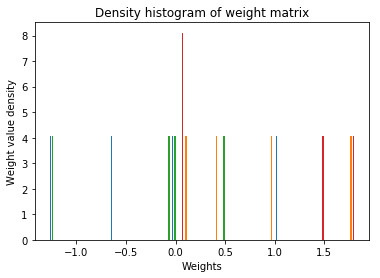

In [121]:
plt.hist(hidden_weight.numpy(), bins=50, density=True)
plt.title("Density histogram of weight matrix")
plt.xlabel('Weights')
plt.ylabel('Weight value density')
plt.show()

MP Distribution Demo
---

/home/jjiangan/PycharmProjects/RandomMatrix/input_pca.py:21: RuntimeWarning: invalid value encountered in true_divide
  Prcm = (Q / (2 * np.pi)) * np.sqrt((d_plus - d) * (d - d_minus)) / d  # distribution of assumed eigen values


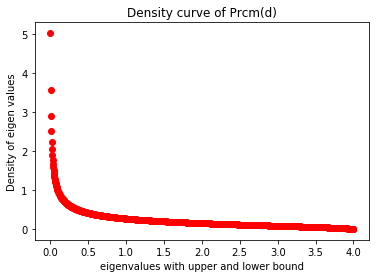

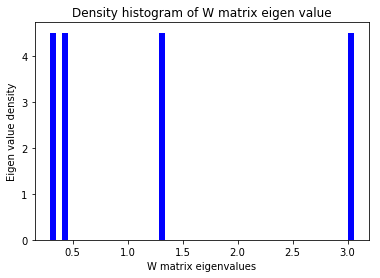

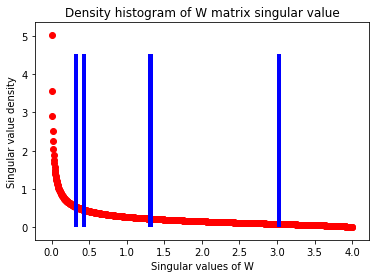

In [122]:
# compute empirical eigen density of Guassian noise matrix
m, n = hidden_weight.shape
d, Prcm = compute_mp_dist(m, n)
vt_w, s_w, u_w = compute_eigen_iid(m, n, solver='svd')

# show curve
plt.hist(s_w.get(), bins=50, color='b', density=True)
plt.scatter(d, Prcm, color='r')
plt.title("Density histogram of W matrix singular value")
plt.xlabel('Singular values of W')
plt.ylabel('Singular value density')
plt.show()

Correlation Matrix Analysis
---

In [123]:
# compute correlation matrix and svd on that
hidden_cor = np.corrcoef(hidden_weight)
u, s, vt = np.linalg.svd(hidden_cor)
recommand_dim = len(s[s>4.0])

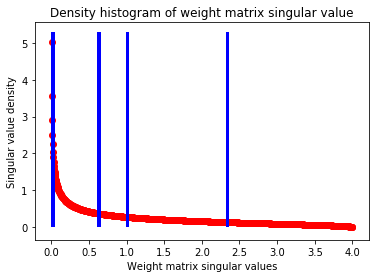

In [124]:
plt.hist(s, bins=50, color='b', density=True)
plt.scatter(d, Prcm, color='r')
plt.title("Density histogram of weight matrix singular value")
plt.xlabel('Weight matrix singular values')
plt.ylabel('Singular value density')
plt.show()

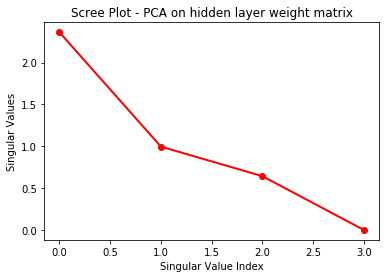

In [125]:
plt.plot(np.arange(s.shape[0]), s, 'ro-', linewidth=2)
plt.title("Scree Plot - PCA on hidden layer weight matrix")
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Values')
plt.show()

Perform PCA - M-P Law
---

In [126]:
pca = PCA(recommand_dim)
train_data_reduced = pca.fit_transform(hidden_weight)
print("{} dimension has been reserved".format(pca.n_components_))
print("explained ratio is {}".format(sum(pca.explained_variance_ratio_)))

0 dimension has been reserved
explained ratio is 0


In [127]:
d_u, d_s, d_v = np.linalg.svd(hidden_weight)
d_u = d_u[:,:recommand_dim]
d_s = d_s[:recommand_dim]
d_v = d_v[:recommand_dim, :]

Perform PCA - 90% Explained Rate
---

In [128]:
pca = PCA(0.9)
train_data_reduced = pca.fit_transform(hidden_weight)
print("{} dimension has been reserved".format(pca.n_components_))
print("explained ratio is {}".format(sum(pca.explained_variance_ratio_)))

3 dimension has been reserved
explained ratio is 1.0


In [129]:
d_u, d_s, d_v = np.linalg.svd(hidden_weight)
d_u = d_u[:,:pca.n_components_]
d_s = d_s[:pca.n_components_]
d_v = d_v[:pca.n_components_, :]

Perform Testing
---

In [130]:
model.fc2.weight.data = hidden_weight
%time Mlp.test(model)


Test set: Average loss: 0.4561, Accuracy: 8727/10000 (87%)

CPU times: user 27.8 ms, sys: 377 ms, total: 405 ms
Wall time: 636 ms


Perform Testing Reduced
---

In [131]:
model.fc2.weight.data = torch.Tensor(np.dot(d_u.dot(np.diag(d_s)), d_v))
%time Mlp.test(model)


Test set: Average loss: 4.1659, Accuracy: 3862/10000 (39%)

CPU times: user 35.8 ms, sys: 406 ms, total: 442 ms
Wall time: 735 ms
